# Bertopic Results

- dataset: 

In [2]:
import pandas as pd
import os

In [3]:
# describe the dataset 
DATA = "/VData/scro4316/ct_prevalence/calvin_posts_cleaned.parquet"
df = pd.read_parquet(DATA)
# print the row count per topic per platform 
display(df.groupby(['platform', 'topic']).size().unstack(fill_value=0))



topic,KEYWORDS_9_11,KEYWORDS_ALIEN,KEYWORDS_COVID19,KEYWORDS_MOON,KEYWORDS_NWO
platform,,,,,
4chan,594,10657,16369,1038,33980
X,3721,14078,34998,747,32517
bluesky,575,11500,27487,586,13094
fediverse,113,3408,6096,146,2849
gab,800,0,62795,754,48373
gettr,268,1325,28834,108,11556
truthsocial,2076,8375,98878,988,76189


In [4]:
# load topic results of top 10 topics per platform per CT
RESULTS = "/VData/scro4316/ct_prevalence/bertopic_results"

platforms = df['platform'].unique().tolist()
topics = df['topic'].unique().tolist()

df_results = pd.DataFrame()
for platform in platforms:
    for topic in topics:
        file_path = f"{RESULTS}/{topic}_{platform}/bertopic_results_{topic}_{platform}.csv"
        if os.path.exists(file_path):
            df_temp = pd.read_csv(file_path)
            df_temp['platform'] = platform
            df_temp['topic'] = topic
            df_results = pd.concat([df_results, df_temp], ignore_index=True)            


In [12]:
df_results.to_csv("/VData/scro4316/ct_prevalence/bertopic_results_all_platforms_topics.csv", index=False)

In [20]:
# let's regenerate the label again with gpt5.1 model
# did it with 5_llm_label.py file
df_results = pd.read_csv("/VData/scro4316/ct_prevalence/bertopic_results_all_platforms_topics_gpt5.csv")
df_results.columns  



Index(['topic_id', 'topic_size', 'representative_words', 'representative_docs',
       'llm_label', 'platform', 'topic', 'gpt5.1'],
      dtype='object')

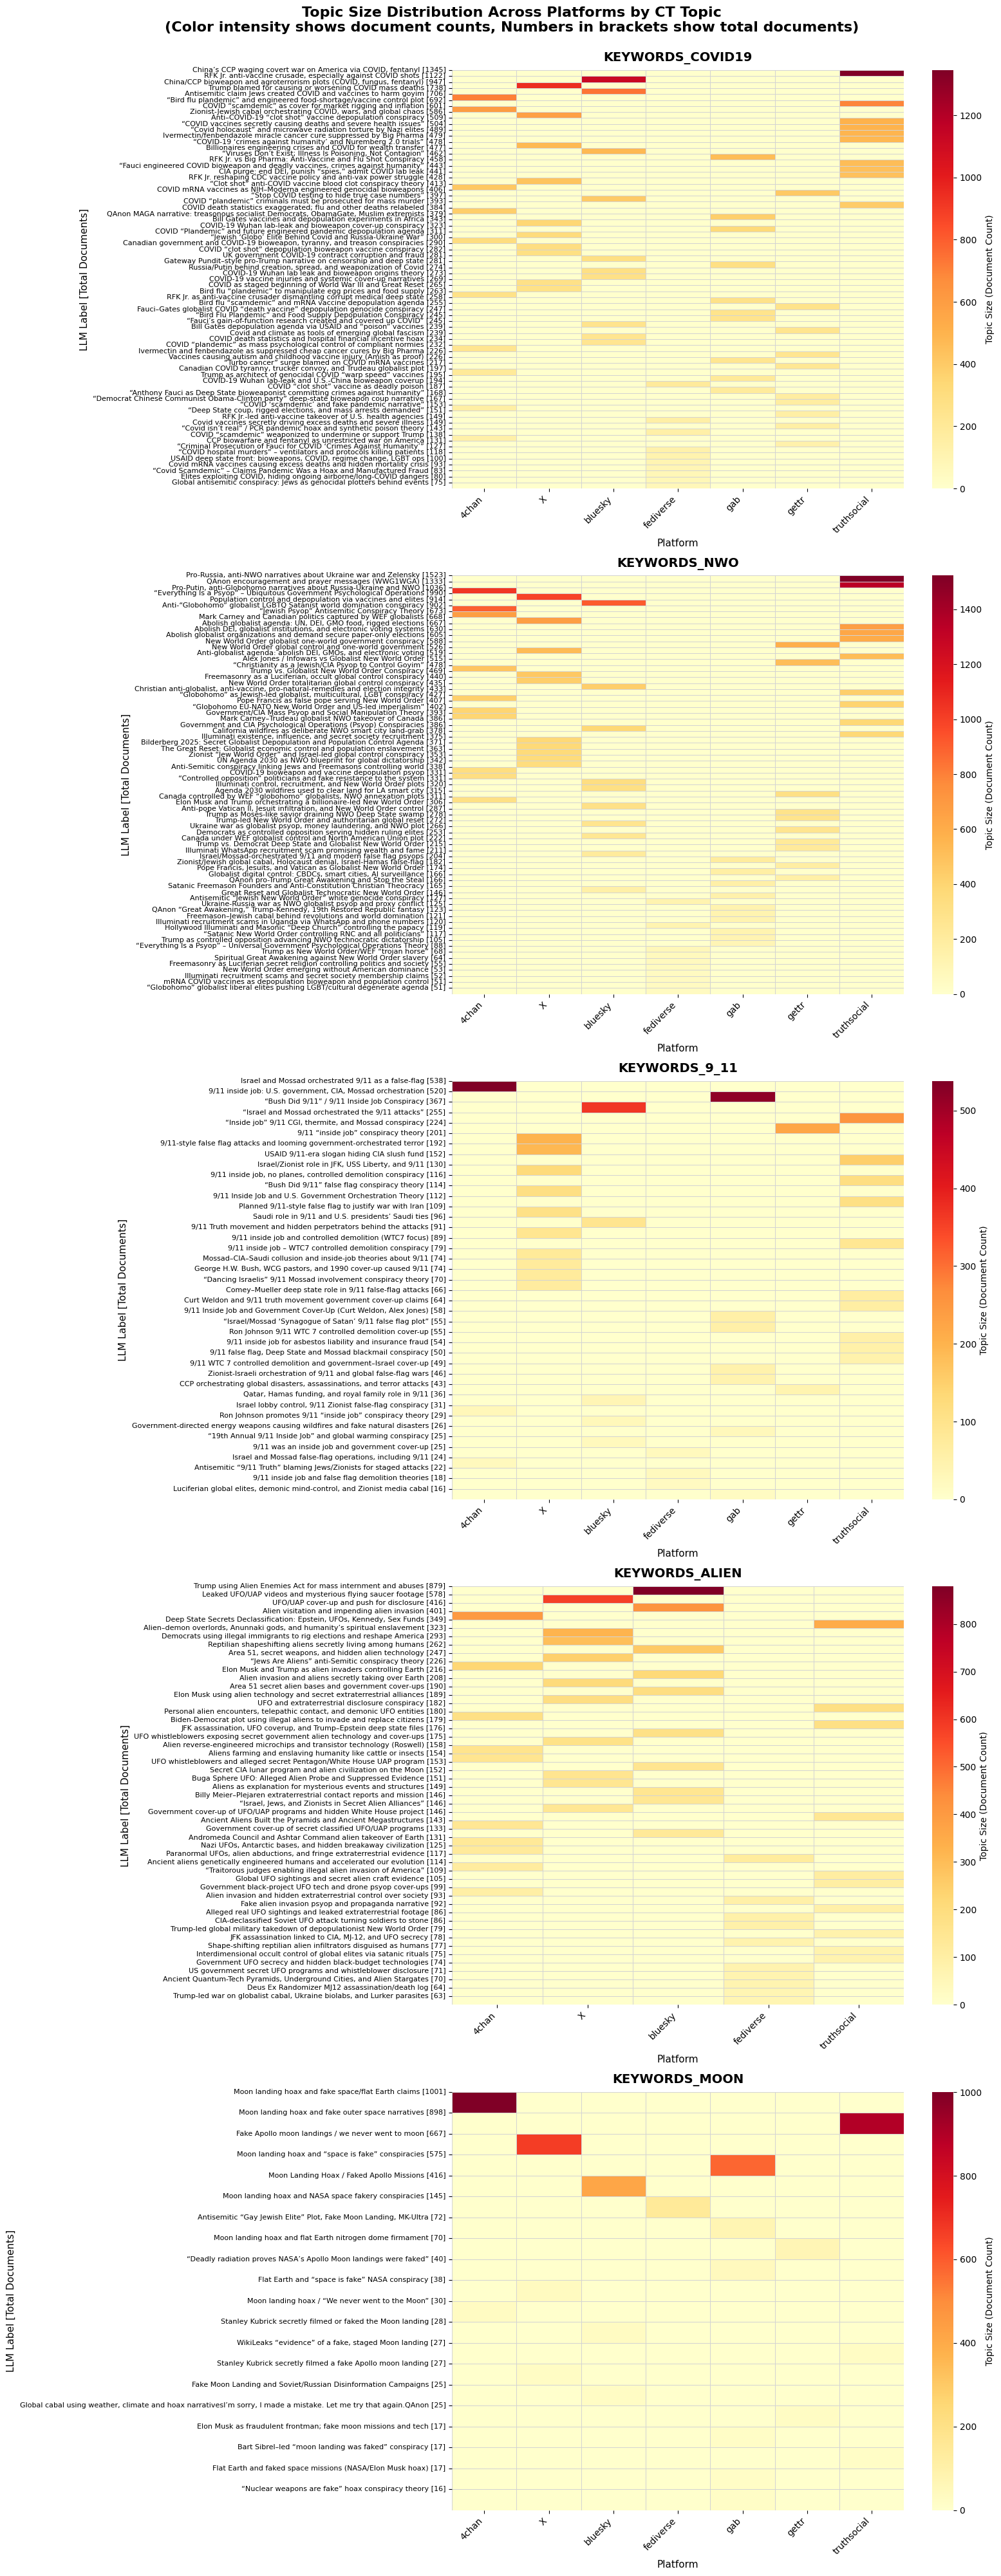

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get unique CT topics
ct_topics = df_results['topic'].unique()

# Create subplots - one per CT topic
fig, axes = plt.subplots(len(ct_topics), 1, figsize=(16, max(8, len(ct_topics)*8)))

# Make axes iterable if only one topic
if len(ct_topics) == 1:
    axes = [axes]

for idx, ct_topic in enumerate(ct_topics):
    # Filter data for this CT topic
    topic_data = df_results[df_results['topic'] == ct_topic]
    
    # Create pivot table: sum of topic_size per platform
    pivot_data = topic_data.pivot_table(
        values='topic_size',
        index='gpt5.1',
        columns='platform',
        aggfunc='sum',  # Sum the topic sizes
        fill_value=0
    )
    
    # Calculate total size across all platforms and sort by it
    total_size = pivot_data.sum(axis=1).sort_values(ascending=False)
    pivot_data = pivot_data.loc[total_size.index]
    
    # Modify index to include total document count
    pivot_data.index = [f"{label} [{int(total_size[label])}]" for label in pivot_data.index]
    
    # Adjust figure height based on number of topics
    num_topics = len(pivot_data)
    
    # Create heatmap
    ax = axes[idx]
    sns.heatmap(
        pivot_data,
        annot=False,  # Remove number annotations
        cmap='YlOrRd',
        cbar_kws={'label': 'Topic Size (Document Count)'},
        linewidths=0.5,
        linecolor='lightgray',
        ax=ax
    )
    
    ax.set_title(f'{ct_topic}', fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel('Platform', fontsize=11)
    ax.set_ylabel('LLM Label [Total Documents]', fontsize=11)
    
    # Show ALL y-axis labels without skipping any
    ax.set_yticks(range(len(pivot_data)))
    ax.set_yticklabels(pivot_data.index, rotation=0, fontsize=8, ha='right')
    
    # Rotate x-axis labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)

plt.suptitle('Topic Size Distribution Across Platforms by CT Topic\n(Color intensity shows document counts, Numbers in brackets show total documents)', 
             fontsize=16, fontweight='bold', y=0.9995)
plt.tight_layout()
plt.show()

In [29]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

# Get unique CT topics
ct_topics = df_results['topic'].unique()

# Create subplots - one per CT topic
fig = make_subplots(
    rows=len(ct_topics), 
    cols=1,
    subplot_titles=[f'<b>{topic}</b>' for topic in ct_topics],
    vertical_spacing=0.03,
    row_heights=[0.2] * len(ct_topics) if len(ct_topics) > 1 else [1.0]
)

for idx, ct_topic in enumerate(ct_topics, 1):
    # Filter data for this CT topic
    topic_data = df_results[df_results['topic'] == ct_topic]
    
    # Create pivot table: sum of topic_size per platform
    pivot_data = topic_data.pivot_table(
        values='topic_size',
        index='gpt5.1',
        columns='platform',
        aggfunc='sum',
        fill_value=0
    )
    
    # Calculate total size and sort
    total_size = pivot_data.sum(axis=1).sort_values(ascending=False)
    pivot_data = pivot_data.loc[total_size.index]
    
    # Create labels with counts
    y_labels = [f"{label} [{int(total_size[label])}]" for label in pivot_data.index]
    
    # Create hovertext with full information
    hovertext = []
    for i, topic_label in enumerate(pivot_data.index):
        row = []
        for j, platform in enumerate(pivot_data.columns):
            value = pivot_data.iloc[i, j]
            hover = f"<b>Topic:</b> {topic_label}<br>" \
                   f"<b>Platform:</b> {platform}<br>"
                  
            row.append(hover)
        hovertext.append(row)
    
    # Add heatmap
    fig.add_trace(
        go.Heatmap(
            z=pivot_data.values,
            x=pivot_data.columns,
            y=y_labels,
            colorscale='YlOrRd',
            hovertemplate='%{hovertext}<extra></extra>',
            hovertext=hovertext,
            colorbar=dict(
                title="Document<br>Count",
                len=0.9/len(ct_topics),
                y=1 - (idx-0.5)/len(ct_topics),
                yanchor='middle'
            ),
            showscale=True
        ),
        row=idx, col=1
    )
    
    # Update axes
    fig.update_xaxes(
        title_text="Platform" if idx == len(ct_topics) else "",
        tickangle=45,
        row=idx, col=1
    )
    fig.update_yaxes(
        title_text="LLM Label [Total Documents]",
        tickfont=dict(size=8),
        row=idx, col=1
    )

# Update layout
fig.update_layout(
    title_text="<b>Topic Size Distribution Across Platforms by CT Topic</b><br>" \
               "<sub>Color intensity shows document counts, Numbers in brackets show total documents</sub>",
    height=300 * len(ct_topics),
    showlegend=False,
    font=dict(size=10)
)

fig.show()

# Save as HTML for GitHub viewing
fig.write_html("/VData/scro4316/ct_prevalence/bertopic_pipeline/topic_heatmap_interactive.html")
print("Interactive plot saved to: topic_heatmap_interactive.html")

Interactive plot saved to: topic_heatmap_interactive.html
